<a id = "table_of_contents"></a>
# Table of contents

[Import of libraries](#imports)

[Global variables](#global_variables)

[Sales import and generate a full df with all data and records](#generate_full_df_with_all_records)

[Join the full_df with gb_df](#join_dfs)

[Generate additional features](#create_new_features)

-->[Date and shop_id features](#feature_1)

-->[Date and item_category features](#feature_3)

[Join full sales df with all the features generated](#join_dfs_with_features)

[Basic model train](#basic_model)

[Feature importance](#feature_importance_1)

[Predict and model evaluation](#predict_and_model_evaluation_1)

[Submission to Kaggle](#submission_kaggle)

<a id = "imports"></a>
# Import of libraries
[Go back to the table of contents](#table_of_contents)

In [1]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contents](#table_of_contents)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "generate_full_df_with_all_records"></a>
# Sales import and generate a full df with all data and records
[Go back to the table of contents](#table_of_contents)

In [3]:
sales_df = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv", index_col = 0)

In [4]:
cols_to_drop = [
 "day", "sales_2011", "sales_2012", "sales_2013"
]

sales_df.drop(cols_to_drop, inplace = True, axis = 1)

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345528 entries, 0 to 5345527
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   item             object 
 2   category         object 
 3   department       object 
 4   store            object 
 5   store_code       object 
 6   region           object 
 7   date             object 
 8   sell_price       float64
 9   year             int64  
 10  week             int64  
 11  sales            float64
 12  month            int64  
 13  weekday_int      float64
 14  weekend_sales    float64
 15  event_dummy      float64
 16  event_sales      float64
 17  units            int64  
 18  summer_sales     int64  
 19  christmas_sales  int64  
 20  sales_2014       int64  
 21  sales_2015       int64  
 22  sales_2016       int64  
dtypes: float64(6), int64(9), object(8)
memory usage: 978.8+ MB


In [6]:
sales_df.isnull().sum()

id                 0
item               0
category           0
department         0
store              0
store_code         0
region             0
date               0
sell_price         0
year               0
week               0
sales              0
month              0
weekday_int        0
weekend_sales      0
event_dummy        0
event_sales        0
units              0
summer_sales       0
christmas_sales    0
sales_2014         0
sales_2015         0
sales_2016         0
dtype: int64

In [7]:
sales_df.rename(columns={'id': 'unique_id', 'units': 'item_cnt_day', 'sell_price': 'item_price', "sales" : "revenue"}, inplace=True)

In [8]:
encoder = LabelEncoder()
encoder.fit(sales_df["store_code"])
sales_df["store_code"] = encoder.transform(sales_df["store_code"])
sales_df["store_code"] = LabelEncoder().fit_transform(sales_df["store_code"])

In [9]:
sales_df.store_code.value_counts()

1    548543
0    547433
3    546363
9    544480
5    542533
2    540362
6    530524
8    530252
7    518746
4    496292
Name: store_code, dtype: int64

In [10]:
print(len(sales_df))
sales_df.drop(sales_df[sales_df['store_code'] == 0].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 2].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 3].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 4].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 5].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 6].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 7].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 8].index, inplace = True)
sales_df.drop(sales_df[sales_df['store_code'] == 9].index, inplace = True)
print(len(sales_df))

5345528
548543


In [11]:
z = sales_df.revenue.mean()
z

37.36220921605054

In [12]:
print(z)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['revenue'] <= z].index, inplace = True)
print(len(sales_df))

37.36220921605054
548543
145034


In [13]:
type(sales_df["date"].iloc[0])

str

In [14]:
# convert to datetime the date column
# specify the format since otherwise it might give some problems
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%Y-%m-%d")

In [15]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()

In [16]:
max_date_sales

Timestamp('2016-04-18 00:00:00')

In [17]:
# how to create a new date
max_date_test = datetime(2016, 4, 18)

In [18]:
date_range = pd.date_range(min_date, max_date_test, freq = "W")
print("We have a total of {} weeks".format(len(date_range)))
date_range

We have a total of 267 weeks


DatetimeIndex(['2011-03-13', '2011-03-20', '2011-03-27', '2011-04-03',
               '2011-04-10', '2011-04-17', '2011-04-24', '2011-05-01',
               '2011-05-08', '2011-05-15',
               ...
               '2016-02-14', '2016-02-21', '2016-02-28', '2016-03-06',
               '2016-03-13', '2016-03-20', '2016-03-27', '2016-04-03',
               '2016-04-10', '2016-04-17'],
              dtype='datetime64[ns]', length=267, freq='W-SUN')

In [19]:
unique_id = sales_df["unique_id"].unique()

In [20]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

664563

We will be working with a DataFrame resampled by Months. We must resample the sales_df.

In [21]:
# # set index
sales_df["revenue"] = sales_df["item_cnt_day"] * sales_df["item_price"]

In [22]:
sales_df.head(5)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
5,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,5.77,2011,...,26.0,4.0,0.0,0.0,25,0,0,0,0,0
39,ACCESORIES_1_012_BOS_2,ACCESORIES_1_012,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,7.95,2011,...,15.0,5.0,0.0,0.0,9,0,0,0,0,0
49,ACCESORIES_1_015_BOS_2,ACCESORIES_1_015,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,0.96,2011,...,23.0,49.0,0.0,0.0,74,0,0,0,0,0
90,ACCESORIES_1_023_BOS_2,ACCESORIES_1_023,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,4.58,2011,...,23.0,4.0,0.0,0.0,13,0,0,0,0,0
113,ACCESORIES_1_029_BOS_2,ACCESORIES_1_029,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,9.90,2011,...,19.0,1.0,0.0,0.0,7,0,0,0,0,0


In [23]:
sales_df.item_price.describe()

count    145034.000000
mean          6.526455
std           5.232513
min           0.240000
25%           2.980000
50%           4.850000
75%           8.460000
max          38.520000
Name: item_price, dtype: float64

In [24]:
print(len(sales_df))

145034


In [25]:
st = time.time()

gb_df = sales_df.set_index("date")

# # groupby shop_id and item_id
gb_df = gb_df.groupby(["unique_id"])

# # resample the sales to a monthly basis
gb_df = gb_df.resample("W").agg({'item_cnt_day':np.sum, "item_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))

Total time in minutes to preprocess took 0.5492831826210022


In [26]:
gb_df.head(2)

,unique_id,date,item_cnt_day,item_price,revenue
0,ACCESORIES_1_001_BOS_2,2013-11-10,6,10.99,65.94
1,ACCESORIES_1_001_BOS_2,2013-11-17,0,NaN,0.00


In [27]:
print(len(gb_df))

423222


In [28]:
gb_df.to_pickle("gb_df.pkl")
sales_df.to_pickle("sales_df.pkl")

<a id = "join_dfs"></a>
# Join the full_df with gb_df
[Go back to the table of contents](#table_of_contents)

Now that we have the sales_df resampled by months, and we have created a cartesian product (all possible combinations of months, shop_id and item_id), let's merge the df.

In [29]:
PATH_DATA = "../input/df-time-series"
gb_df = pd.read_pickle("./gb_df.pkl")
sales_df = pd.read_pickle("./sales_df.pkl")

In [30]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()
# how to create a new date
max_date_test = datetime(2016, 4, 18)
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range
unique_id = sales_df["unique_id"].unique()
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

We have a total of 61 months


151829

In [31]:
sales_df.head(2)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
5,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,5.77,2011,...,26.0,4.0,0.0,0.0,25,0,0,0,0,0
39,ACCESORIES_1_012_BOS_2,ACCESORIES_1_012,ACCESORIES,ACCESORIES_1,Roxbury,1,Boston,2011-03-07,7.95,2011,...,15.0,5.0,0.0,0.0,9,0,0,0,0,0


In [32]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df = pd.merge(full_df, gb_df, on = ['date','unique_id'], how = 'left')

full_df["item_cnt_day"] = np.clip(full_df["item_cnt_day"], 0, 30)

In [33]:
print(len(sales_df))
print(len(gb_df))

145034
423222


In [34]:
gb_df.revenue.describe()

count    423222.000000
mean         37.577563
std          94.508990
min           0.000000
25%           0.000000
50%           0.000000
75%          50.200000
max        3331.040000
Name: revenue, dtype: float64

In [35]:
y = gb_df["revenue"].mean()
print(y)
print(len(gb_df))
gb_df.drop(gb_df[gb_df['revenue'] <= y].index, inplace = True)
print(len(gb_df))

37.5775627212196
423222
144103


In [36]:
gb_df.head()

,unique_id,date,item_cnt_day,item_price,revenue
0,ACCESORIES_1_001_BOS_2,2013-11-10,6,10.99,65.94
2,ACCESORIES_1_001_BOS_2,2013-11-24,8,10.99,87.92
4,ACCESORIES_1_001_BOS_2,2013-12-08,6,10.99,65.94
25,ACCESORIES_1_001_BOS_2,2014-05-04,4,10.99,43.96
36,ACCESORIES_1_001_BOS_2,2014-07-20,4,10.99,43.96


In [37]:
print(full_df.shape)

(151829, 5)


In [38]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151829 entries, 0 to 151828
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          151829 non-null  datetime64[ns]
 1   unique_id     151829 non-null  object        
 2   item_cnt_day  13086 non-null   float64       
 3   item_price    4358 non-null    float64       
 4   revenue       13086 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 7.0+ MB


In [39]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145034 entries, 5 to 5345469
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        145034 non-null  object        
 1   item             145034 non-null  object        
 2   category         145034 non-null  object        
 3   department       145034 non-null  object        
 4   store            145034 non-null  object        
 5   store_code       145034 non-null  int64         
 6   region           145034 non-null  object        
 7   date             145034 non-null  datetime64[ns]
 8   item_price       145034 non-null  float64       
 9   year             145034 non-null  int64         
 10  week             145034 non-null  int64         
 11  revenue          145034 non-null  float64       
 12  month            145034 non-null  int64         
 13  weekday_int      145034 non-null  float64       
 14  weekend_sales    14

In [40]:
additional_info = sales_df[["region", "store_code", "store", "category", "item", "department", "unique_id"]].drop_duplicates()

In [41]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = additional_info,
    how = "left",
    on = "unique_id"
)
print(full_df.shape)

(151829, 5)
(151829, 11)


In [42]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151829 entries, 0 to 151828
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          151829 non-null  datetime64[ns]
 1   unique_id     151829 non-null  object        
 2   item_cnt_day  13086 non-null   float64       
 3   item_price    4358 non-null    float64       
 4   revenue       13086 non-null   float64       
 5   region        151829 non-null  object        
 6   store_code    151829 non-null  int64         
 7   store         151829 non-null  object        
 8   category      151829 non-null  object        
 9   item          151829 non-null  object        
 10  department    151829 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 13.9+ MB


In [43]:
full_df["item_cnt_day"].fillna(0, inplace = True)
full_df["item_price"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [44]:
full_df["item_price"] = full_df.groupby("unique_id")["item_price"].apply(lambda series: series.backfill().ffill())

In [45]:
full_df.isnull().sum()

date            0
unique_id       0
item_cnt_day    0
item_price      0
revenue         0
region          0
store_code      0
store           0
category        0
item            0
department      0
dtype: int64

In [46]:
full_df.to_pickle("full_df.pkl")

<a id = "create_new_features"></a>
# Generate additional features
[Go back to the table of contents](#table_of_contents)

In [47]:
PATH_DATA = "../input/df-time-series"
full_df = pd.read_pickle("./full_df.pkl")

In [48]:
encoder = LabelEncoder()
encoder.fit(full_df["region"])
full_df["region"] = encoder.transform(full_df["region"])
full_df["region"] = LabelEncoder().fit_transform(full_df["region"])

encoder = LabelEncoder()
encoder.fit(full_df["category"])
full_df["category"] = encoder.transform(full_df["category"])
full_df["category"] = LabelEncoder().fit_transform(full_df["category"])

encoder = LabelEncoder()
encoder.fit(full_df["department"])
full_df["department"] = encoder.transform(full_df["department"])
full_df["department"] = LabelEncoder().fit_transform(full_df["department"])

encoder = LabelEncoder()
encoder.fit(full_df["item"])
full_df["item"] = encoder.transform(full_df["item"])
full_df["item"] = LabelEncoder().fit_transform(full_df["item"])

In [49]:
def build_ts_features(full_df, gb_list, agg_func, agg_func_name, target_column = "item_cnt_day", verbose = True) -> pd.DataFrame:
    '''
    Based on the full_df you pass and the gb_list, this functions creates Time Series features and returns
    a gb_df.
    '''
    
    # create dynamic name
    feature_name = "_".join(gb_list)
    
    if verbose: print(f"Working with {feature_name}")
    
    # first sales/DataFrame aggregation
    gb_df = full_df.groupby(
        gb_list
    )[target_column].apply(
        agg_func
    ).reset_index().rename(
        columns = {target_column : feature_name + "_" + agg_func_name}
    )
    
    # add lags features
    gb_df[feature_name + "_" + agg_func_name + "_" + "shift_1"] = gb_df.groupby(gb_list[1:])[feature_name + "_" + agg_func_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df

In [50]:
full_df.to_pickle("full_df.pk2")

<a id = "feature_1"></a>
## Date and shop_id features
[Go back to the table of contents](#table_of_contents)

In [51]:
full_df = pd.read_pickle("./full_df.pk2")

In [52]:
st = time.time()

gb_list = ["date", "store_code"]

shop_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_store_code


0.0004493594169616699

In [53]:
shop_sales_features.shape

(61, 4)

In [54]:
st = time.time()

gb_list = ["date", "region"]

region_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_region


0.0004560192426045736

In [55]:
st = time.time()

gb_list = ["date", "department"]

department_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_department


0.0010820150375366211

In [56]:
department_sales_features

,date,department,date_department_sales_sum,date_department_sales_sum_shift_1
0,2011-03-31,0,0.0,NaN
1,2011-03-31,1,0.0,NaN
2,2011-03-31,2,0.0,NaN
3,2011-03-31,3,0.0,NaN
4,2011-03-31,4,0.0,NaN
...,...,...,...,...
422,2016-03-31,2,0.0,0.0
423,2016-03-31,3,0.0,0.0
424,2016-03-31,4,0.0,0.0
425,2016-03-31,5,0.0,0.0


In [57]:
st = time.time()

gb_list = ["date", "item"]

item_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_item


0.24293389717737834

In [58]:
item_sales_features

,date,item,date_item_sales_sum,date_item_sales_sum_shift_1
0,2011-03-31,0,0.0,NaN
1,2011-03-31,1,0.0,NaN
2,2011-03-31,2,0.0,NaN
3,2011-03-31,3,0.0,NaN
4,2011-03-31,4,0.0,NaN
...,...,...,...,...
151824,2016-03-31,2484,0.0,0.0
151825,2016-03-31,2485,0.0,0.0
151826,2016-03-31,2486,0.0,0.0
151827,2016-03-31,2487,0.0,0.0


<a id = "feature_3"></a>
## Date and item_category features
[Go back to the table of contents](#table_of_contents)

In [59]:
st = time.time()

gb_list = ["date", "category"]

month_item_category_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_category


0.000634610652923584

In [60]:
month_item_category_features.shape

(183, 4)

<a id = "join_dfs_with_features"></a>
# Join full sales df with all the features generated
[Go back to the table of contents](#table_of_contents)

In [61]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "store_code"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "category"], how = "left")
full_df = pd.merge(full_df, item_sales_features, on = ["date", "item"], how = "left")
full_df = pd.merge(full_df, department_sales_features, on = ["date", "department"], how = "left")
full_df = pd.merge(full_df, region_sales_features, on = ["date", "region"], how = "left")

full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (151829, 11)
Shape after merge is (151829, 21)


In [62]:
full_df.to_pickle("full_df.pk3")
full_df = pd.read_pickle("./full_df.pk3")

In [63]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151829 entries, 0 to 151828
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               151829 non-null  datetime64[ns]
 1   unique_id                          151829 non-null  object        
 2   sales                              151829 non-null  float64       
 3   item_price                         151829 non-null  float64       
 4   revenue                            151829 non-null  float64       
 5   region                             151829 non-null  int64         
 6   store_code                         151829 non-null  int64         
 7   store                              151829 non-null  object        
 8   category                           151829 non-null  int64         
 9   item                               151829 non-null  int64         
 10  department          

In [64]:
# save the file

st = time.time()

full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

et = time.time()
(et - st)/60

0.0007388989130655924

<a id = "basic_model"></a>
# Basic model train
[Go back to the table of contents](#table_of_contents)

In [65]:
# load the preprocessed data
full_df = pd.read_pickle("./FULL_DF_ALL_FEATURES.pkl")
full_df["sales"] = np.clip(full_df["sales"], 0, 30)

# delete all the columns where lags features are - 1 (shift(1))
full_df = full_df[full_df["date"] > np.datetime64("2011-01-31")]

In [66]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151829 entries, 0 to 151828
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               151829 non-null  datetime64[ns]
 1   unique_id                          151829 non-null  object        
 2   sales                              151829 non-null  float64       
 3   item_price                         151829 non-null  float64       
 4   revenue                            151829 non-null  float64       
 5   region                             151829 non-null  int64         
 6   store_code                         151829 non-null  int64         
 7   store                              151829 non-null  object        
 8   category                           151829 non-null  int64         
 9   item                               151829 non-null  int64         
 10  department          

In [67]:
full_df.isnull().sum()

date                                    0
unique_id                               0
sales                                   0
item_price                              0
revenue                                 0
region                                  0
store_code                              0
store                                   0
category                                0
item                                    0
department                              0
date_store_code_sales_sum               0
date_store_code_sales_sum_shift_1    2489
date_category_sales_sum                 0
date_category_sales_sum_shift_1      2489
date_item_sales_sum                     0
date_item_sales_sum_shift_1          2489
date_department_sales_sum               0
date_department_sales_sum_shift_1    2489
date_region_sales_sum                   0
date_region_sales_sum_shift_1        2489
dtype: int64

In [68]:
full_df["date_store_code_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_category_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_item_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_department_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_region_sales_sum_shift_1"].fillna(0, inplace = True)

In [69]:
cols_to_drop = [

'revenue',
'store',
"unique_id",
"date_store_code_sales_sum",
"date_category_sales_sum", 
"date_region_sales_sum",
"date_department_sales_sum", 
"date_item_sales_sum"
    
]

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [70]:
full_df.head()

,date,sales,item_price,region,store_code,category,item,department,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1
0,2011-03-31,0.0,0.0,0,1,0,1,0,0.0,0.0,0.0,0.0,0.0
1,2011-03-31,0.0,0.0,0,1,0,7,0,0.0,0.0,0.0,0.0,0.0
2,2011-03-31,0.0,0.0,0,1,0,9,0,0.0,0.0,0.0,0.0,0.0
3,2011-03-31,0.0,0.0,0,1,0,17,0,0.0,0.0,0.0,0.0,0.0
4,2011-03-31,0.0,0.0,0,1,0,23,0,0.0,0.0,0.0,0.0,0.0


In [71]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]

valida_index = [sorted(list(full_df["date"].unique()))[-2]]

test_index = [sorted(list(full_df["date"].unique()))[-1]]

In [72]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [73]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[00:49:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.01582	validation_1-rmse:0.450008
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.75631	validation_1-rmse:0.405006
[2]	validation_0-rmse:2.52573	validation_1-rmse:0.364503
[3]	validation_0-rmse:2.32442	validation_1-rmse:0.328053
[4]	validation_0-rmse:2.14459	validation_1-rmse:0.29525
[5]	validation_0-rmse:1.98778	validation_1-rmse:0.26572
[6]	validation_0-rmse:1.85224	validation_1-rmse:0.239147
[7]	validation_0-rmse:1.72926	validation_1-rmse:0.215234
[8]	validation_0-rmse:1.62674	validation_1-rmse:0.19371
[9]	validation_0-rmse:1.53832	validation_1-rmse:0.174342
[10]	validation_0-rmse:1.46209	validation_1-rmse:0.156908
[11]	validation_0-rmse:1.39514	validation_1-rmse:0.141217
[12]	validation_0-rmse:1.33954	

In [74]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [75]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_10_17_00_49_54.dat


In [76]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[00:50:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<a id = "feature_importance_1"></a>
# Feature importance
[Go back to the table of contents](#table_of_contents)

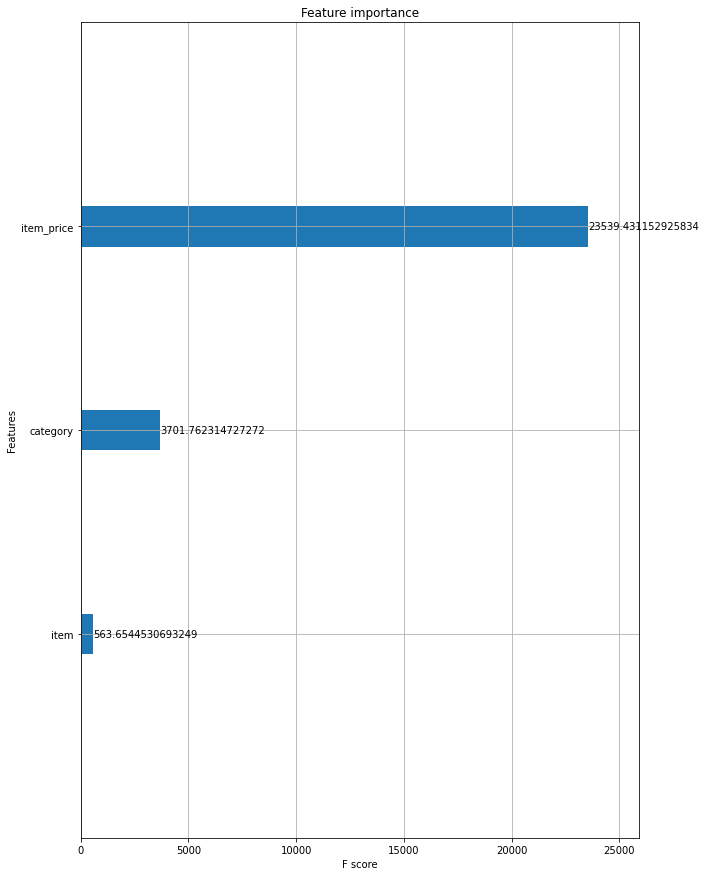

In [77]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_1"></a>
# Predict and model evaluation
[Go back to the table of contents](#table_of_contents)

In [78]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

0.001428157091140747

In [79]:
if "sales_predicted" in X_test.columns:
    X_test.drop("sales_predicted", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["sales_predicted"] = np.clip(Y_test_predict, 0, 30)

In [80]:
X_test.head()

,item_price,region,store_code,category,item,department,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1,sales_predicted
149340,0.0,0,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.001428
149341,0.0,0,1,0,7,0,0.0,0.0,0.0,0.0,0.0,0.001428
149342,0.0,0,1,0,9,0,0.0,0.0,0.0,0.0,0.0,0.001428
149343,0.0,0,1,0,17,0,0.0,0.0,0.0,0.0,0.0,0.001428
149344,0.0,0,1,0,23,0,0.0,0.0,0.0,0.0,0.0,0.001428


In [81]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 149340 to 151828
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   item_price                         2489 non-null   float64
 1   region                             2489 non-null   int64  
 2   store_code                         2489 non-null   int64  
 3   category                           2489 non-null   int64  
 4   item                               2489 non-null   int64  
 5   department                         2489 non-null   int64  
 6   date_store_code_sales_sum_shift_1  2489 non-null   float64
 7   date_category_sales_sum_shift_1    2489 non-null   float64
 8   date_item_sales_sum_shift_1        2489 non-null   float64
 9   date_department_sales_sum_shift_1  2489 non-null   float64
 10  date_region_sales_sum_shift_1      2489 non-null   float64
 11  sales_predicted                    2489 non-null 

In [82]:
X_test.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/STOCK_PREDICTION_DF_11.csv", index = False)

In [83]:
X_test["unique_id"] = X_test["store_code"].map(str) + "-" + X_test["item"].map(str)

In [84]:
X_test_short = X_test[["unique_id", "sales_predicted"]]

In [85]:
PATH_DATA = "../input/df-time-series"

In [86]:
test_index = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv", index_col = 0)

In [87]:
test_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345528 entries, 0 to 5345527
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   item             object 
 2   category         object 
 3   department       object 
 4   store            object 
 5   store_code       object 
 6   region           object 
 7   date             object 
 8   sell_price       float64
 9   year             int64  
 10  week             int64  
 11  sales            float64
 12  month            int64  
 13  day              int64  
 14  weekday_int      float64
 15  weekend_sales    float64
 16  event_dummy      float64
 17  event_sales      float64
 18  units            int64  
 19  summer_sales     int64  
 20  christmas_sales  int64  
 21  sales_2011       int64  
 22  sales_2012       int64  
 23  sales_2013       int64  
 24  sales_2014       int64  
 25  sales_2015       int64  
 26  sales_2016       int64  
dtypes: float64(6

In [88]:
test_index["id"] = test_index["id"].map(str)
test_index.rename(columns = {"id":"unique_id"}, inplace = True)

In [89]:
FINAL_STOCK_PRED_DF = pd.merge(test_index, X_test_short, left_on = "unique_id", right_on = "unique_id", how = "left")

In [90]:
FINAL_STOCK_PRED_DF.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/FINAL_STOCK_PRED_DF_11.csv", index = False)

In [91]:
FINAL_STOCK_PRED_DF.head(2)

,unique_id,item,category,department,store,store_code,region,date,sell_price,year,...,units,summer_sales,christmas_sales,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales_predicted
0,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-03-07,5.28,2011,...,4,0,0,4,0,0,0,0,0,NaN
1,ACCESORIES_1_002_BOS_3,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,2011-03-07,5.28,2011,...,2,0,0,2,0,0,0,0,0,NaN
